## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler


from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from keras.utils import pad_sequences

## Import

In [2]:
df = pd.read_csv("output_w_label.csv").drop('Unnamed: 0', axis=1)
df.head()

,ID,POS,SEQ,PreTime,PreSD,PreMean,InTime,InSD,InMean,PostTime,PostSD,PostMean,gene_id,label
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1,ENSG00000004059,0
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9,ENSG00000004059,0
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6,ENSG00000004059,0
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4,ENSG00000004059,0
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2,ENSG00000004059,0


In [3]:
def split(x):

    unique_x =x[['gene_id', 'label']].drop_duplicates()
    X_train, X_non_train, y_train, y_non_train = train_test_split(
        unique_x['gene_id'], unique_x['label'], test_size=0.2, stratify=unique_x['label'], random_state=42
    )

    X_test, X_val , y_test, y_val = train_test_split(
        X_non_train, y_non_train, test_size=0.5, stratify=y_non_train, random_state=42
    )

    return X_train, X_val, X_test

gene_train, gene_val, gene_test = split(df) 
    

In [112]:
train = df[df['gene_id'].isin(gene_train)].copy()

train_in_low_mean  = train.loc[train['InMean'] < 110, 'InMean'].mean()
train_in_high_mean = train.loc[train['InMean'] > 110, 'InMean'].mean()
train_pre_low_mean  = train.loc[train['PreMean'] < 110, 'PreMean'].mean()
train_pre_high_mean = train.loc[train['PreMean'] > 110, 'PreMean'].mean()

train['InMean_group'] = (train['InMean'] > 110).astype(int)
train['PreMean_group'] = (train['PreMean'] > 110).astype(int)

train.loc[:,'InMean'] = np.where(
    train['InMean'] < 110,
    train['InMean'] - train.loc[train['InMean'] < 110, 'InMean'].mean(),
    train['InMean'] - train.loc[train['InMean'] > 110, 'InMean'].mean()
)

train.loc[:,'PreMean'] = np.where(
    train['PreMean'] < 110,
    train['PreMean'] - train.loc[train['PreMean'] < 110, 'PreMean'].mean(),
    train['PreMean'] - train.loc[train['PreMean'] > 110, 'PreMean'].mean()
)

numeric_cols = train.select_dtypes(include='number').columns.difference(['ID', 'POS'])

# Group by ID and POS
summary = train.groupby(['ID', 'POS'])[numeric_cols].mean().reset_index()
summary['InMean_pval'] = train.groupby(['ID', 'POS'])['InMean'].apply(lambda x: normaltest(x).pvalue).values
summary['PreMean_pval'] = train.groupby(['ID', 'POS'])['PreMean'].apply(lambda x: normaltest(x).pvalue).values

summary['InMean_pval'] = -np.log10(summary['InMean_pval'].clip(lower=1e-300))
summary['PreMean_pval'] = -np.log10(summary['PreMean_pval'].clip(lower=1e-300))

summary.head()

,ID,POS,InMean,InMean_group,InSD,InTime,PostMean,PostSD,PostTime,PreMean,PreMean_group,PreSD,PreTime,label,InMean_pval,PreMean_pval
0,ENST00000000233,244,3.319634,1.000000,7.382162,0.009373,80.570270,4.386989,0.007345,4.272713,0.945946,4.223784,0.008264,0.0,13.689657,7.600920
1,ENST00000000233,261,1.318535,0.238372,3.226535,0.006813,94.290698,3.016599,0.007710,-3.239854,0.482558,3.216424,0.006609,0.0,160.078404,300.000000
2,ENST00000000233,316,0.317803,0.000000,3.642703,0.007416,89.364324,2.087146,0.007555,4.948509,0.000000,2.940541,0.007570,0.0,6.705385,37.530150
3,ENST00000000233,332,-0.792724,0.000000,2.899200,0.008632,89.154000,2.236520,0.006101,8.838641,0.995000,6.476350,0.010620,0.0,8.120697,26.013757
4,ENST00000000233,368,-0.639334,1.000000,5.870303,0.011479,85.178788,4.260253,0.010019,-2.592117,0.994949,6.415051,0.010701,0.0,5.294977,0.359784


In [59]:
exclude_cols = ['ID', 'POS', 'SEQ', 'gene_id', 'label', 'InMean_group', 'PreMean_group']

# Select only numeric columns, excluding the specified ones
cols_to_scale = [c for c in summary.select_dtypes(include='number').columns if c not in exclude_cols]

# Initialize and fit the scaler
scaler = StandardScaler()
summary[cols_to_scale] = scaler.fit_transform(summary[cols_to_scale])

In [60]:
summary.head()

,ID,POS,InMean,InMean_group,InSD,InTime,PostMean,PostSD,PostTime,PreMean,PreMean_group,PreSD,PreTime,label,InMean_pval,PreMean_pval
0,ENST00000000233,244,0.927485,1.000000,1.020820,0.739205,-1.140603,1.580963,0.223710,0.874825,0.945946,-0.062582,0.089016,0.0,0.413869,-0.116031
1,ENST00000000233,261,0.407257,0.238372,-0.884984,-0.777013,1.641680,0.047828,0.506226,-0.529149,0.482558,-0.582532,-0.838537,0.0,7.362795,6.422380
2,ENST00000000233,316,0.147096,0.000000,-0.694126,-0.420152,0.642690,-0.992004,0.386297,1.001120,0.000000,-0.724930,-0.300120,0.0,0.082333,0.553224
3,ENST00000000233,332,-0.141609,0.000000,-1.035103,0.300422,0.600040,-0.824891,-0.737736,1.728122,0.995000,1.100085,1.409268,0.0,0.149516,0.295703
4,ENST00000000233,368,-0.101732,1.000000,0.327469,1.986366,-0.206070,1.439175,2.291375,-0.408098,0.994949,1.068445,1.454243,0.0,0.015382,-0.277952


In [136]:
feature_cols = [
    'InMean', 'InMean_group', 'InSD', 'InTime',
    'PostMean', 'PostSD', 'PostTime',
    'PreMean', 'PreMean_group', 'PreSD', 'PreTime',
    'InMean_pval', 'PreMean_pval'
]

sequences = []
labels = []


bootstrap_factor = 5   # generate ~5x more sequences
sample_fraction = 0.66 # fraction of reads to sample per bootstrap to reduce correlation


for _ in range(bootstrap_factor):
    # For each (ID, POS) group
    for (id_val, pos_val), group in train.groupby(['ID', 'POS']):
        # Sample a fraction of reads
        sampled = group.sample(frac=sample_fraction, replace=True)
        all_sequences.append(sampled[feature_cols].values)
        all_labels.append(sampled['label'].iloc[-1])  # sequence-level label


KeyError: "['InMean_pval', 'PreMean_pval'] not in index"

In [132]:
augmented_sequences = []
augmented_labels = []

# Parameters
window_size = 3
augment_factor = 7   # number of augmented copies per minority sequence
noise_std = 0.075     # adjust depending on feature scale

# Loop through all positive sequences
for seq, label in zip(sequences, labels):
    if label == 1:
        # Slide a small window across the short sequence
        for i in range(len(seq) - window_size + 1):
            sub_seq = seq[i:i+window_size]

            # Generate perturbed copies
            for _ in range(augment_factor):
                noise = np.random.normal(0, noise_std, sub_seq.shape)
                noisy_seq = sub_seq + noise
                augmented_sequences.append(noisy_seq)
                augmented_labels.append(1)


In [133]:
all_sequences = sequences + augmented_sequences
all_labels = labels + augmented_labels

# Pad to same length
X = pad_sequences(all_sequences, dtype='float32', padding='post', value=0.0)
y = np.array(all_labels)

print(f"Input shape (num_sequences, max_timesteps, num_features): {X.shape}")

Input shape (num_sequences, max_timesteps, num_features): (15410, 118, 13)


In [7]:
# --- Parameters ---
augment_factor = 2       # number of bootstrapped copies
sample_fraction = 0.8   # fraction of reads per (ID, POS)
feature_cols_base = [
    'InMean', 'InMean_group', 'InSD', 'InTime',
    'PostMean', 'PostSD', 'PostTime',
    'PreMean', 'PreMean_group', 'PreSD', 'PreTime'
]

# --- 1. Prepare raw train dataframe ---
train = df[df['gene_id'].isin(gene_train)].copy()


train_in_low_mean  = train.loc[train['InMean'] < 110, 'InMean'].mean()
train_in_high_mean = train.loc[train['InMean'] > 110, 'InMean'].mean()
train_pre_low_mean  = train.loc[train['PreMean'] < 110, 'PreMean'].mean()
train_pre_high_mean = train.loc[train['PreMean'] > 110, 'PreMean'].mean()


# Compute groupings
train['InMean_group'] = (train['InMean'] > 110).astype(int)
train['PreMean_group'] = (train['PreMean'] > 110).astype(int)

train.loc[:, 'InMean'] = np.where(
    train['InMean'] < 110,
    train['InMean'] - train.loc[train['InMean'] < 110, 'InMean'].mean(),
    train['InMean'] - train.loc[train['InMean'] > 110, 'InMean'].mean()
)
train.loc[:, 'PreMean'] = np.where(
    train['PreMean'] < 110,
    train['PreMean'] - train.loc[train['PreMean'] < 110, 'PreMean'].mean(),
    train['PreMean'] - train.loc[train['PreMean'] > 110, 'PreMean'].mean()
)

numeric_cols = train.select_dtypes(include='number').columns.difference(['ID','POS'])

# --- 2. Bootstrapping at read level ---
bootstrapped_rows = []

for _ in range(augment_factor):
    for (id_val, pos_val), group in train.groupby(['ID','POS']):
        sampled = group.sample(frac=sample_fraction, replace=True)
        bootstrapped_rows.append(sampled)

train_boot = pd.concat(bootstrapped_rows, ignore_index=True)

# --- 3. Aggregate per (ID, POS) after bootstrapping ---
summary = train_boot.groupby(['ID','POS'])[numeric_cols].mean().reset_index()

# --- 4. Compute p-values per (ID, POS) on bootstrapped reads ---
summary['InMean_pval'] = train_boot.groupby(['ID','POS'])['InMean'].apply(lambda x: normaltest(x).pvalue).values
summary['PreMean_pval'] = train_boot.groupby(['ID','POS'])['PreMean'].apply(lambda x: normaltest(x).pvalue).values

# Log-transform p-values
summary['InMean_pval'] = -np.log10(summary['InMean_pval'].clip(lower=1e-300))
summary['PreMean_pval'] = -np.log10(summary['PreMean_pval'].clip(lower=1e-300))

# --- 5. Scale numeric columns ---
exclude_cols = ['ID','POS','SEQ','gene_id','label','InMean_group','PreMean_group']
cols_to_scale = [c for c in summary.select_dtypes(include='number').columns if c not in exclude_cols]

scaler = StandardScaler()
summary[cols_to_scale] = scaler.fit_transform(summary[cols_to_scale])

# --- 6. Prepare LSTM sequences per transcript (ID) ---
feature_cols = feature_cols_base + ['InMean_pval', 'PreMean_pval']

sequences = []
labels = []

for _, group in summary.groupby('ID'):
    seq_features = group[feature_cols].values
    sequences.append(seq_features)
    labels.append(group['label'].iloc[-1])  # sequence-level label

# --- 7. Pad sequences ---
X = pad_sequences(sequences, dtype='float32', padding='post', value=0.0)
y = np.array(labels)

print(f"LSTM input shape after bootstrapping and aggregation: {X.shape}")

LSTM input shape after bootstrapping and aggregation: (4644, 118, 13)


In [5]:
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X.shape[1], X.shape[2])),
    LSTM(14, return_sequences=False),
    Dense(6, activation='relu'),
    Dense(3, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification (adjust if needed)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# === Step 7: Train the model ===
history = model.fit(X, y, epochs=8, batch_size=100, validation_split=0.1)

C:\Users\Jessy Yip\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 118, 13)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 14)                  │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              21 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,683 (6.57 KB)

 Trainable params: 1,683 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.9715 - loss: 0.5209 - val_accuracy: 0.9656 - val_loss: 0.3588
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9715 - loss: 0.2178 - val_accuracy: 0.9656 - val_loss: 0.1426
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9715 - loss: 0.1386 - val_accuracy: 0.9656 - val_loss: 0.1366
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.9715 - loss: 0.1338 - val_accuracy: 0.9656 - val_loss: 0.1343
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9715 - loss: 0.1307 - val_accuracy: 0.9656 - val_loss: 0.1323
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9715 - loss: 0.1277 - val_accuracy: 0.9656 - val_loss: 0.1313
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9715 - loss: 0.1251 - val_accuracy: 0.9656 - val_loss: 0.1308
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9715 - loss: 0.1227 - val_accuracy: 0.9656 - 

In [8]:
# --- Validation data preparation ---

val = df[df['gene_id'].isin(gene_val)].copy()

# Step 1: Derive grouping columns (same logic as training)
val['InMean_group'] = (val['InMean'] > 110).astype(int)
val['PreMean_group'] = (val['PreMean'] > 110).astype(int)

# Step 2: Normalize relative to the same 110 thresholds, using TRAIN means (important!)
# Use the same means computed from the training data

val.loc[:, 'InMean'] = np.where(
    val['InMean'] < 110,
    val['InMean'] - train_in_low_mean,
    val['InMean'] - train_in_high_mean
)

val.loc[:, 'PreMean'] = np.where(
    val['PreMean'] < 110,
    val['PreMean'] - train_pre_low_mean,
    val['PreMean'] - train_pre_high_mean
)

# Step 3: Aggregate by ID, POS
numeric_cols = val.select_dtypes(include='number').columns.difference(['ID', 'POS'])
summary_val = val.groupby(['ID', 'POS'])[numeric_cols].mean().reset_index()

print(summary_val)

# Step 4: Compute normality test p-values and log-transform them
summary_val['InMean_pval'] = val.groupby(['ID', 'POS'])['InMean'].apply(lambda x: normaltest(x).pvalue).values
summary_val['PreMean_pval'] = val.groupby(['ID', 'POS'])['PreMean'].apply(lambda x: normaltest(x).pvalue).values

summary_val['InMean_pval'] = -np.log10(summary_val['InMean_pval'].clip(lower=1e-300))
summary_val['PreMean_pval'] = -np.log10(summary_val['PreMean_pval'].clip(lower=1e-300))

# Step 5: Use the SAME scaler (from training)
exclude_cols = ['ID', 'POS', 'SEQ', 'gene_id', 'label', 'InMean_group', 'PreMean_group']
cols_to_scale = [c for c in summary_val.select_dtypes(include='number').columns if c not in exclude_cols]

# Use the fitted scaler from training (do not refit)
summary_val[cols_to_scale] = scaler.transform(summary_val[cols_to_scale])

# Step 6: Build validation sequences (NO augmentation)
feature_cols = [
    'InMean', 'InMean_group', 'InSD', 'InTime',
    'PostMean', 'PostSD', 'PostTime',
    'PreMean', 'PreMean_group', 'PreSD', 'PreTime',
    'InMean_pval', 'PreMean_pval'
]

val_sequences = []
val_labels = []

for _, group in summary_val.groupby('ID'):
    seq_features = group[feature_cols].values
    val_sequences.append(seq_features)
    val_labels.append(group['label'].iloc[-1])  # same label logic as training

# Pad sequences to same length as training
max_len = X.shape[1]  # use the length from training set
X_val = pad_sequences(val_sequences, dtype='float32', padding='post', value=0.0, maxlen=max_len)
y_val = np.array(val_labels)

print(f"Validation input shape: {X_val.shape}")


                    ID   POS    InMean  InMean_group      InSD    InTime  \
0      ENST00000005286  2622  5.341604      1.000000  5.116452  0.013450   
1      ENST00000005286  2792 -5.337224      0.000000  4.324000  0.006163   
2      ENST00000005286  2812 -3.626138      1.000000  6.770968  0.008692   
3      ENST00000005286  2857 -1.625130      1.000000  8.409375  0.009022   
4      ENST00000005286  2867  1.680639      0.000000  4.565588  0.006704   
...                ...   ...       ...           ...       ...       ...   
15997  ENST00000641834  1348 -4.938282      0.917808  4.929726  0.007300   
15998  ENST00000641834  1429 -5.929774      0.884058  9.105797  0.010305   
15999  ENST00000641834  1531 -6.784693      0.890625  4.759688  0.006877   
16000  ENST00000641834  1537  0.669278      1.000000  6.552982  0.007419   
16001  ENST00000641834  1693 -6.233253      0.788462  8.702885  0.006908   

        PostMean    PostSD  PostTime   PreMean  PreMean_group     PreSD  \
0      77.28

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step
Validation Performance Metrics
ROC AUC: 0.7015
PR AUC: 0.1208
Accuracy: 0.9546
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Confusion Matrix:
[[694   0]
 [ 33   0]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.9546    1.0000    0.9768       694
           1     0.0000    0.0000    0.0000        33

    accuracy                         0.9546       727
   macro avg     0.4773    0.5000    0.4884       727
weighted avg     0.9113    0.9546    0.9324       727



C:\Users\Jessy Yip\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jessy Yip\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jessy Yip\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

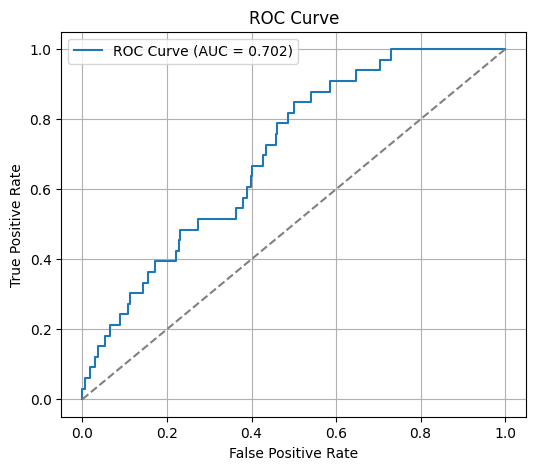

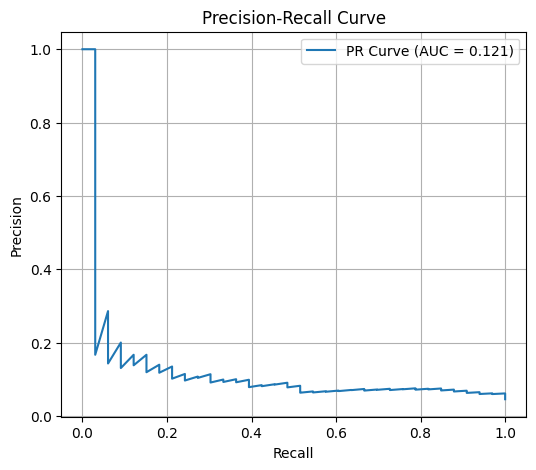

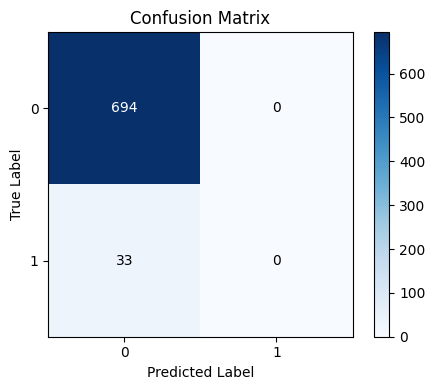

In [9]:
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report,
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)

# --- Step 1: Get model predictions ---
y_pred_prob = model.predict(np.nan_to_num(X_val, nan=0.0))

# Flatten predictions if needed
if y_pred_prob.ndim > 1:
    y_pred_prob = y_pred_prob.squeeze()

# Ensure y_val is 1D and integer
y_val = np.array(y_val).ravel().astype(int)

# --- Step 2: Threshold and metrics ---
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).astype(int)

roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
pr_auc = auc(recall, precision)

accuracy = accuracy_score(y_val, y_pred_class)
precision_val = precision_score(y_val, y_pred_class, zero_division=0)
recall_val = recall_score(y_val, y_pred_class, zero_division=0)
f1 = f1_score(y_val, y_pred_class, zero_division=0)
cm = confusion_matrix(y_val, y_pred_class)

# --- Step 3: Print results ---
print("Validation Performance Metrics")
print("=" * 35)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred_class, digits=4))

# --- Step 4: ROC Curve ---
fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 5: Precision-Recall Curve ---
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# --- Step 6: Confusion Matrix Heatmap using Matplotlib only ---
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(cm.shape[1]), np.arange(cm.shape[1]))
plt.yticks(np.arange(cm.shape[0]), np.arange(cm.shape[0]))

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
